# OHBM 2020 - Open Science Room - Neurolang

## Synonyms

### Background
While recent advances in automated meta-analysis techniques, like NeuroSynth[1], address long-standing inferential problems in the neuroimaging literature, they still present many challenges for cognitive neuroscientists, and some limitations remain to be addressed. Neurosynth[1], for example, is based on a purely lexical coding approach that does not allow for the distinction between different terms with similar meanings (e.g. `pain`, `nociception}`, and `noxious}`) and does not allow closely related constructs to be easily distinguished (e.g. `physical pain` vs. `emotional pain`)[2].

### Our approach
We believe that the hierarchical structure of information provided by ontologies is ideally suited to tackle this type of problems. Ontologies are a formal way of representing knowledge in which concepts are described both by their meaning and their relationship to each other[3].

We propose then a possible solution to this issue, taking advantage of the relationships between entities that ontologies provide us, unifying different terms that have the same meaning. They allow us to use related terms without having to know them in advance. We will show how through this improvement we can enhance meta-analysis techniques, by using results derived from the combination of our initial tag and the information defined in ontologies.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import stats_helper, datasets_helper
from neurolang.frontend.probabilistic_frontend import ProbabilisticFrontend
from rdflib import RDFS
from nilearn import plotting
from matplotlib import pyplot as plt
from operator import eq
from neurolang.expressions import Constant, Symbol
import numpy as np
import nibabel as nib

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/cm.py:159: MatplotlibDeprecationWarning: 
The revcmap function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use Colormap.reversed() instead.
  _cmaps_data[_cmapname_r] = _cm.revcmap(_cmapspec)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 fro

We use Neurolang to process the IOBC ontology. We are using the information provided by the ontology, to look for all the terms (and their alternative names) related to the class of biostimuli (We use the URI of this class for a matter of simplicity). 

The pain string included inside the symbol acts as a filter. This way, our query only returns those values where `label(x, 'Pain')` is true. Then we will use this information to perform a search in the NeuroSynth database.

In [2]:
nl = ProbabilisticFrontend()
datasets_helper.load_pain_datasets(nl)

Dataset created in neurolang_data/ontologies


/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/mask.py:232: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  return self.volume.get_header()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:624: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  old_data = self.data.to_dense()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:634: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  self.data = data.fillna(0.0).to_sparse()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:3451: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use 

In [3]:
paths = 'neurolang_data/ontologies/IOBC_1_4_0.xrdf'
nl.load_ontology(paths)

In [4]:
label = nl.new_symbol(name=str(RDFS.label))
related = nl.new_symbol(name='http://www.w3.org/2004/02/skos/core#related')
altLabel = nl.new_symbol(name='http://www.w3.org/2004/02/skos/core#altLabel')
subclass_of = nl.new_symbol(name=str(RDFS.subClassOf))

@nl.add_symbol
def first_word(name: str) -> str:
    return name.split(" ")[0]

with nl.environment as e:
    e.related_biostimulation_terms[e.word] = (e.word == 'pain')
    
    e.related_biostimulation_terms[e.alternative_names] = (
        subclass_of(e.biostimulation_subclass, 'http://purl.jp/bio/4/id/200906066643737725') &
        label(e.pain_entity, 'Pain') & 
        related(e.pain_entity, e.biostimulation_subclass) &
        altLabel(e.biostimulation_subclass, e.alternative_names)
    )
    e.synonyms[e.short_name] = (
        (e.short_name == nl.symbols.first_word(e.alternative_names)) & 
        e.related_biostimulation_terms(e.alternative_names)
    )
    

The fact of having obtained the synonyms of the term `pain` directly from the ontology, allows us to avoid having to declare each of the terms to be evaluated and to be able to obtain this information directly from `e.synonyms(e.term)` without the need to know it beforehand.

In [5]:
with nl.scope as e:    
    e.p_act[e.id_voxel, e.term, e.id_study] = (
        e.p_voxel_study[e.id_voxel, e.id_study] & 
        e.p_term_study[e.term, e.study] & 
        e.p_study[e.id_study]
    )
    
    e.act_term[e.term, e.id_voxel] = (
        e.synonyms[e.term] &
        e.p_act[e.id_voxel, e.term, e.id_study]
    )
 
    e.xyz_given_term[e.x, e.y, e.z] = (
        e.act_term[e.term, e.id_voxel] &
        e.xyz_neurosynth[e.x, e.y, e.z, e.id_voxel]
    )
    
    nl_results = nl.solve_query(e.xyz_given_term[e.x, e.y, e.z])

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


λ{C{first_word: typing.Callable[[str], str]}: str}(C{'alternative_names': ColumnStr})
λ{C{first_word: typing.Callable[[str], str]}: str}(C{'alternative_names': ColumnStr})


In [9]:
result_data = nl_results.value.as_pandas_dataframe()
prob_column = result_data.drop(['x', 'y', 'z'], axis=1).columns[0]
result_data = result_data.rename(columns={f'{prob_column}': "prob"})
result_data.head()

,x,y,z,prob
0,-70.0,-38.0,-8.0,4.993190e-11
1,-70.0,-38.0,-6.0,4.993190e-11
2,-70.0,-36.0,-8.0,4.993190e-11
3,-70.0,-36.0,-6.0,4.993190e-11
4,-70.0,-36.0,-4.0,4.993190e-11


In [13]:
#result_data = result.value.to_numpy()
#prob_terms = aux.load_neurosynth_pain_prob_terms()

import nibabel as nib
from neurolang.regions import region_union
import neurolang.frontend as fe

def create_region(x, y, z, it):
    voxels = nib.affines.apply_affine(
        np.linalg.inv(it.affine), np.c_[x, y, z]
    )
    return fe.ExplicitVBR(voxels, it.affine, image_dim=it.shape)

nsh = fe.neurosynth_utils.NeuroSynthHandler()
ns_ds = nsh.ns_load_dataset()
it = ns_ds.image_table

regions = []
vox_prob = []
for x, y, z, p in result_data.values:
    r_overlay = create_region(x, y, z, it.masker.volume)
    vox_prob.append((r_overlay.voxels, p))
    regions.append(r_overlay)

regions = region_union(regions)

prob_img_nl = nib.spatialimages.SpatialImage(
    np.zeros(regions.image_dim, dtype=float), affine=it.masker.volume.affine
)
for v, p in vox_prob:
    prob_img_nl.dataobj[tuple(v.T)] = p


/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/mask.py:232: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  return self.volume.get_header()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:624: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  old_data = self.data.to_dense()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:634: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  self.data = data.fillna(0.0).to_sparse()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:3451: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use 

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/displays.py:1239: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if (not isinstance(cut_coords, collections.Sequence) and
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


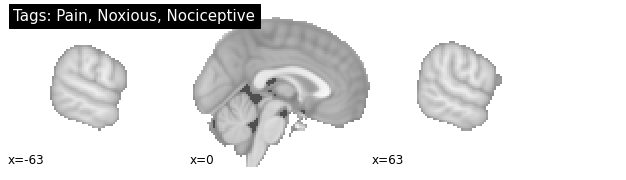

In [14]:
plotting.plot_stat_map(
    prob_img_nl, 
    title='Tags: Pain, Noxious, Nociceptive', 
    cmap='PuBuGn',
    display_mode='x',
    cut_coords=np.linspace(-63, 63, 3),
)

Now we can analyze the results by plotting the p-values obtained

In [14]:
res, p_values_corrected, p_value_image = stats_helper.compute_p_values(prob_img, q=1e-2, n=100)

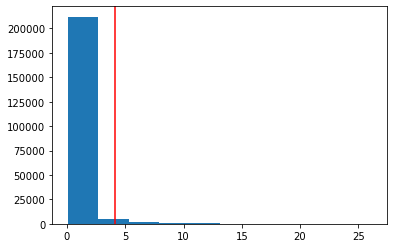

In [15]:
plt.hist(-np.log10(res))
plt.axvline(-np.log10(p_values_corrected), c='r')

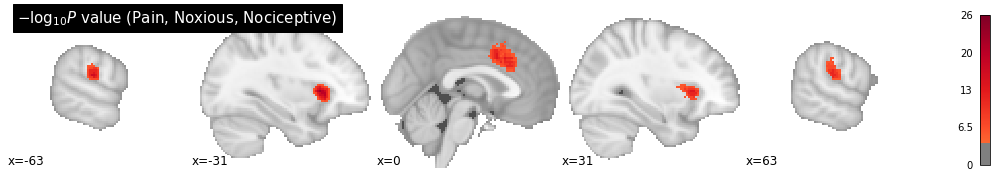

In [16]:
plotting.plot_stat_map(
    p_value_image, 
    title=r'$-\log_{10} P$ value (Pain, Noxious, Nociceptive)', 
    threshold=-np.log10(p_values_corrected), 
    cmap='YlOrRd',
    display_mode='x',
    cut_coords=np.linspace(-63, 63, 5),
)

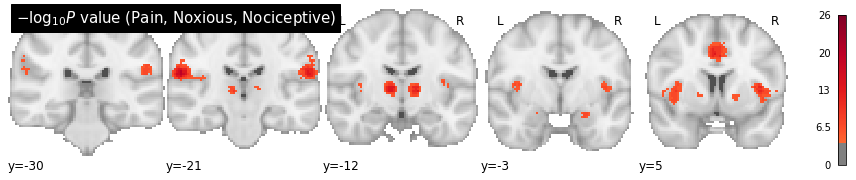

In [17]:
plotting.plot_stat_map(
    p_value_image, title=r'$-\log_{10} P$ value (Pain, Noxious, Nociceptive)', 
    threshold=-np.log10(p_values_corrected),
    cmap='YlOrRd',
    display_mode='y',
    cut_coords=np.linspace(-30, 5, 5),
)

This example is a first demonstration of how, using the hierarchical information provided by ontologies, we are able to obtain results enriched with information from heterogeneous sources.

We obtained a combination of results from the NeuroSynth database, without the need to know all the synonyms available for the term `pain`, and avoiding having to iterate for each one of them.


#### References
[1] Yarkoni, T.: Neurosynth core tools v0.3.1, DOI: 10.5281/zenodo.9925 (2014). <br/>
[2] Yarkoni, T., Poldrack, R. A., Nichols, T. E., Van Essen, D. C. & Wager, T. D: Large-scale automated synthesis of human functional neuroimaging data. Nat. Methods 8, 665–670, DOI: 10.1038/nmeth.1635 (2011). <br/>
[3] Bard, J.B.L., Rhee, S.Y.: Ontologies in biology: design, applications and future challenges. Nature Reviews   Genetics5(3), 213–222 (Mar   2004). https://doi.org/10.1038/nrg1295, https://www.nature.com/articles/nrg1295
[4] Bienvenu, M.: Ontology-Mediated Query Answering: Harnessing Knowledge to GetMore From Data, p. 4 <br/>
[5] Cali, A., Gottlob, G., Lukasiewicz, T.: A general Datalog-based framework for tractable query answering over ontologies. Journal of Web Semantics 14, 57–83 (Jul 2012). https://doi.org/10.1016/j.websem.2012.03.001, http://www.sciencedirect.com/science/article/pii/S1570826812000388 <br/>
[6] Cali, A., Gottlob, G., Pieris, A.:Towards more expressive ontology languages: The query answering problem. Artificial Intelligence 193, 87-128 (Dec2012). https://doi.org/10.1016/j.artint.2012.08.002,http://www.sciencedirect.com/science/article/pii/S0004370212001026 <br/>
[7] Gottlob, G., Orsi, G., Pieris, A.: Query Rewriting and Optimization for Ontological Databases. ACM Transactions  on Database Systems 39 (May 2014). https://doi.org/10.1145/2638546 <br/>